Notebook on $k$-means clustering
---
`$k$-means is a classic method for clustering`
- $k$ is an integer number that produces a fixed number of cluster, which are associated with a center and each data point is assigned to a cluster.
- It solves the following optimization problem:
$$
\mathrm{minimize} \sum^{n}_{i=1} \Vert( \mathbf{x}_i - \mathbf{\mu}_{z_i} \Vert^2)  \quad \mathrm{w.r.t} \quad \left(\mathbf{\mu}, z\right)
$$
where $\mu_k$ is the center of the $k^\mathrm{th}$ cluster, $z_i$ is an index of the cluster for point $\mathbf{x}_i$

In [2]:
import NMFk
import Mads
import Clustering
import Statistics, Distances
import Random

Random.seed!(2021)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1582857574541001022\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10560541221133184415\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1582857574541001022\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

MersenneTwister(2021)

Let us generate 3 random signals:

In [3]:
a = rand(15)
b = rand(15)
c = rand(15)
[a b c]

15×3 Matrix{Float64}:
 0.405796   0.705261   0.592091
 0.0657738  0.0900316  0.802722
 0.398162   0.0208244  0.782083
 0.163816   0.0835003  0.316525
 0.783094   0.634718   0.803177
 0.134115   0.0967049  0.0685768
 0.883121   0.664583   0.73253
 0.386875   0.61921    0.846265
 0.242105   0.402028   0.361288
 0.131588   0.0956702  0.390644
 0.085331   0.219395   0.344963
 0.330099   0.637804   0.094793
 0.654601   0.590012   0.45923
 0.467328   0.947572   0.271188
 0.889334   0.936274   0.567385

The singals look like this:

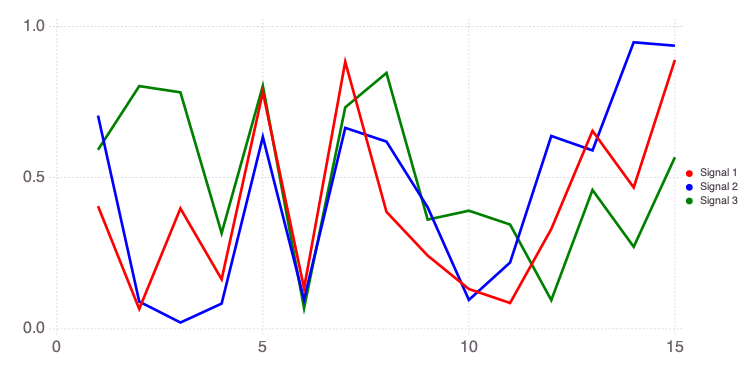

In [4]:
import Cairo
Mads.plotseries([a b c])

We can collect the 3 signal vectors into a signal matrix `W`:

In [5]:
W = [a b c]

15×3 Matrix{Float64}:
 0.405796   0.705261   0.592091
 0.0657738  0.0900316  0.802722
 0.398162   0.0208244  0.782083
 0.163816   0.0835003  0.316525
 0.783094   0.634718   0.803177
 0.134115   0.0967049  0.0685768
 0.883121   0.664583   0.73253
 0.386875   0.61921    0.846265
 0.242105   0.402028   0.361288
 0.131588   0.0956702  0.390644
 0.085331   0.219395   0.344963
 0.330099   0.637804   0.094793
 0.654601   0.590012   0.45923
 0.467328   0.947572   0.271188
 0.889334   0.936274   0.567385

Now we can mix the signals in matrix `W` to produce a data matrix `X` representing data collected at 5 sensors (e.g., measurement devices or wells at different locations).

Each of the 5 sensors is observing some mixture of the signals in `W`.

The way the 3 signals are mixed at the sensors is represented by the mixing matrix `H`.

Let us define the mixing matrix `H` as:

In [6]:
H = [1 10 0 0 1; 0 1 1 5 2; 3 0 0 1 5]

3×5 Matrix{Int64}:
 1  10  0  0  1
 0   1  1  5  2
 3   0  0  1  5

Each column of the `H` matrix defines how the 3 signals are represented in each sensors.

For example, the first sensor (column 1 above) detects only Signals 1 and 3; Signal 2 is missing because `H[2,1]` is equal to zero.

The second sensor (column 2 above) detects Signals 1 and 2; Signal 3 is missing because `H[3,2]` is equal to zero.

The entries of `H` matrix also define the proportions at which the signals are mixed.

For example, the first sensor (column 1 above) detects Signal 3 times stronger than Signal 1.

The data matrix `X` is formed by multiplying `W` and `H` matrices. `X` defines the actual data observed.

In [8]:
X = permutedims(W * H)

5×15 Matrix{Float64}:
 2.18207   2.47394    2.74441    1.11339    …  2.03229   1.28089   2.59149
 4.76322   0.74777    4.00244    1.72166       7.13603   5.62085   9.82962
 0.705261  0.0900316  0.0208244  0.0835003     0.590012  0.947572  0.936274
 4.11839   1.25288    0.886205   0.734027      3.40929   5.00905   5.24876
 4.77677   4.25945    4.35023    1.91344       4.13078   3.71841   5.59881

The data matrix `X` looks like this:

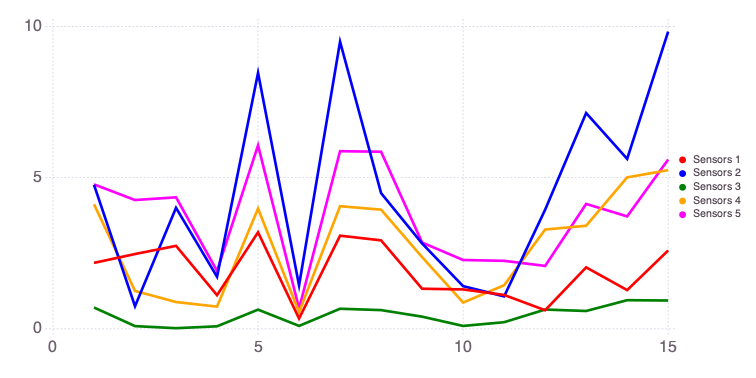

In [10]:
Mads.plotseries(X'; name="Sensors")

### Run $k$-means clustering allowing up to 4 clusters

In [11]:
result = Clustering.kmeans(X, 3); # run K-means for the 3 clusters

A clustering function would return an object containing both the resulting clustering (e.g. assignments of points to the clusters) and the information about the clustering algorithm (e.g. the number of iterations and whether it converged).

### check if the number of clusters are same as specified

In [12]:
@assert Clustering.nclusters(result) == 3

### view some basic features for $k$-meanus clustering

In [13]:
M = result.centers # center of clusters

5×3 Matrix{Float64}:
 1.27948   1.9633   2.95494
 1.53577   4.99155  9.26369
 0.164555  0.58678  0.745192
 1.20356   3.44151  4.42699
 2.37016   4.15208  5.84739

In [14]:
size = Clustering.counts(result) # cluster size ==> number of data points for each cluster

3-element Vector{Int64}:
 6
 6
 3

### get the assignments of points to clusters

In [15]:
a = Clustering.assignments(result)

15-element Vector{Int64}:
 2
 1
 2
 1
 3
 1
 3
 2
 1
 1
 1
 2
 2
 2
 3

### plot with the point color mapped to the assigned cluster index

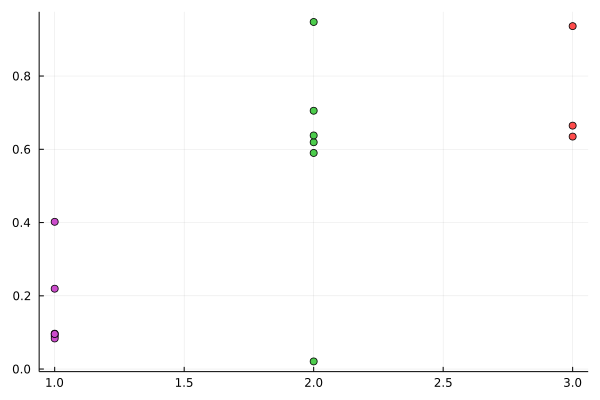

In [37]:
import Plots
Plots.scatter(a, b, marker_z=result.assignments, color=:lightrainbow, legend=false)

### We ran single $k$-means clustering but we don't know if 3 is the best cluster for this data
- for validation of $k$-means clustering results there are several metrics
- one of them is silhouette width
- others are elbow, cross tabulation, rand index, variation of information, V-measure, mutual information
- among them silhouette is the best metric; however, these metrics are dataset dependent
### Silhouette width measures the quality of each clustering by quantifying distance of each cluster from its neighboring clusters
- The Silhouette width for $i$ data point is a cosine norm:
    $$
    s_i = \frac{b_i - a_i}{\mathrm{max}\left(a_i, b_i\right)} 
    $$ 
where
- $a_i$ is the average distance from $i$ to the other points in the same cluster $z_i$
- $b_i$ is the average distance from the i to the points in the $k$-th cluster
### to compute Silhouette width, we need distance matrix of features/data

In [26]:
import Distances
dists = Distances.pairwise(Distances.SqEuclidean(), X)

15×15 Matrix{Float64}:
  0.0       25.0664   11.9925    30.4324    …   6.58604   3.51974   27.8428
 25.0664     0.0      10.8135     8.57255      45.9215   40.3072   100.971
 11.9925    10.8135    0.0       13.8272       17.0646   23.017     55.4082
 30.4324     8.57255  13.8272     0.0          42.4899   37.5121   102.616
 16.4226    71.0708   33.0018    77.8877        7.19274  18.4336     4.15117
 44.4028    18.4029   26.0175     2.25732   …  55.7145   48.2617   122.544
 24.4163    87.6903   43.0732    91.3704       10.1328   23.8946     1.92483
  1.8332    24.2571   12.2357    37.0655       11.0739    9.80641   30.5188
 11.3434     8.95245   7.99698    4.92288      21.8467   15.8339    66.7993
 29.1889     5.89136  13.0966     0.282237     43.4378   37.6646   103.452
 28.5369     6.03277  15.985      1.05335   …  45.1449   36.1253   105.076
 11.1125    22.8164   15.8253    12.0009       16.4576    9.0313    54.9448
  6.58604   45.9215   17.0646    42.4899        0.0       5.71748   

### find silhouette width

In [27]:
sil_width = Statistics.mean(Clustering.silhouettes(result, dists))

0.5881906669707156

### We did for one cluster. Now, perform analyses for multiple $k$ values

In [29]:
cl_num    = [2, 3, 4, 5, 6, 7]
sil_width = []
for cluster in cl_num
    results          = Clustering.kmeans(X, cluster)
    silhouette_width = Statistics.mean(Clustering.silhouettes(results, dists))
    push!(sil_width, silhouette_width)
    display(silhouette_width)
end

0.722172126175015

0.4409544217285092

0.5669914967453166

0.4660328443803485

0.49493919065195285

0.4323455271566419

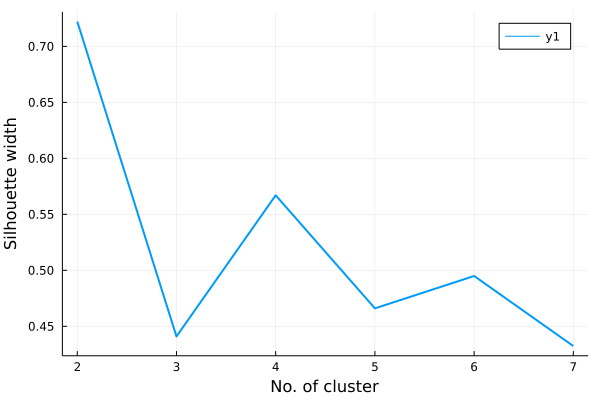

In [30]:
Plots.plot(cl_num, sil_width, xlabel="No. of cluster", ylabel="Silhouette width", linewidth=2)

### Here, $k = 2$ has highest Silhouette value. However, three is the closest to two. From my experience, $k=2$ provides highest silhouette width than larger $k$ values. Potential cause is two cluster can easilty demarcate the boundaries in a dataset. However, it does not mean that they represent the data accurately. So, it is better to look for $k$ value greater than `two`. Here, $k=4$ does it and also the actual data also has `four` distinct classification.

### There are more clustering tools available on Julia